# Analyze naturally occurring mutations at sites of strong escape
This Python Jupyter notebook sees how many naturally occuring mutations are observed at each site of strong escape

## Set up analysis
Import Python modules:

In [1]:
import collections
import copy
import math
import os

import dms_variants.utils

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

Read the configuration file:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read escape profiles config, which tells which sets to make plots for:

In [3]:
with open(config['escape_profiles_config']) as f:
    escape_profiles_config = yaml.safe_load(f)

Create output directory:

In [4]:
os.makedirs(config['gisaid_mutations_dir'], exist_ok=True)

Read counts of naturally ocurring mutations:

In [5]:
print(f"Reading mutation counts from {config['gisaid_mutation_counts']}")

mut_counts = pd.read_csv(config['gisaid_mutation_counts'])

Reading mutation counts from results/GISAID_mutations/mutation_counts.csv


Read sites of "strong escape" from all antibodies / sera:

In [6]:
print(f"Reading sites of strong escape from {config['strong_escape_sites']}")

strong_sites = pd.read_csv(config['strong_escape_sites'])

Reading sites of strong escape from results/escape_profiles/strong_escape_sites.csv


Read escape fractions for all antibodies / sera:

In [7]:
print(f"Reading escape fractions from {config['escape_fracs']}")

escape_fracs = (
    pd.read_csv(config['escape_fracs'])
    .query('library == "average"')
    .drop(columns='site')
    .rename(columns={'mutation': 'mutant',
                     'label_site': 'site'})
    [['condition', 'site', 'wildtype', 'mutant', config['mut_metric'], config['site_metric']]]
    )

escape_fracs

Reading escape fractions from results/escape_scores/escape_fracs.csv


,condition,site,wildtype,mutant,mut_escape_frac_epistasis_model,site_total_escape_frac_epistasis_model
0,CB6_400,331,N,A,0.001044,0.03952
1,CB6_400,331,N,D,0.002087,0.03952
2,CB6_400,331,N,E,0.001044,0.03952
3,CB6_400,331,N,F,0.001044,0.03952
4,CB6_400,331,N,G,0.005013,0.03952
...,...,...,...,...,...,...
56497,S309_421,531,T,R,0.041250,0.77760
56498,S309_421,531,T,S,0.038590,0.77760
56499,S309_421,531,T,V,0.043800,0.77760
56500,S309_421,531,T,W,0.044880,0.77760


## Counts of mutations at sites of escape
Get counts of naturally occurring mutations at sites of escape, along with the actual escape values:

First get mutation-level counts:

In [8]:
mutcounts_strong_sites = (
    strong_sites[['condition', 'threshold', 'site']]
    .merge(mut_counts, how='inner', on='site')
    .merge(escape_fracs[['condition', 'site', 'wildtype', config['site_metric']]].drop_duplicates(),
           on=['condition', 'site', 'wildtype'],
           validate='many_to_one')
    .assign(mutation=lambda x: x['wildtype'] + x['site'].astype(str) + x['mutant'])
    .sort_values('count', ascending=False)
    )

Now get site-level counts (aggregating all mutations at a site):

In [9]:
sitecounts_strong_sites = (
    mutcounts_strong_sites
    .assign(mut_count=lambda x: x['mutation'] + ' (' + x['count'].astype(str) + ')')
    .groupby(['condition', 'threshold', 'site', 'wildtype', config['site_metric']])
    .aggregate({'count': 'sum', 'mut_count': ', '.join})
    .rename(columns={'mut_count': 'counts_by_mutation'})
    .reset_index()
    .sort_values('count', ascending=False)
    )

print(f"Here are first few lines showing the most frequently mutated sites of escape:")
display(HTML(sitecounts_strong_sites.head(n=20).to_html(index=False)))

Here are first few lines showing the most frequently mutated sites of escape:


condition,threshold,site,wildtype,site_total_escape_frac_epistasis_model,count,counts_by_mutation
S2H14_105,sensitive,501,N,14.6600,465506,"N501Y (462642), N501T (2810), N501S (30), N501I (18), N501H (4), N501F (1), N501C (1)"
S2H14_105,default,501,N,14.6600,465506,"N501Y (462642), N501T (2810), N501S (30), N501I (18), N501H (4), N501F (1), N501C (1)"
S2H14_105,sensitive_max_mut,501,N,14.6600,465506,"N501Y (462642), N501T (2810), N501S (30), N501I (18), N501H (4), N501F (1), N501C (1)"
CB6_400,sensitive_max_mut,501,N,1.4430,465506,"N501Y (462642), N501T (2810), N501S (30), N501I (18), N501H (4), N501C (1), N501F (1)"
CB6_400,sensitive,501,N,1.4430,465506,"N501Y (462642), N501T (2810), N501S (30), N501I (18), N501H (4), N501F (1), N501C (1)"
COV2-2499_400,sensitive,501,N,0.5019,465506,"N501Y (462642), N501T (2810), N501S (30), N501I (18), N501H (4), N501F (1), N501C (1)"
COV2-2499_400,sensitive_max_mut,501,N,0.5019,465506,"N501Y (462642), N501T (2810), N501S (30), N501I (18), N501H (4), N501F (1), N501C (1)"
S2E12_56,sensitive_max_mut,477,S,1.4840,45028,"S477N (43577), S477R (905), S477I (442), S477G (89), S477T (13), S477V (1), S477A (1)"
COV2-2096_400,default,452,L,2.2170,42047,"L452R (41051), L452Q (735), L452M (255), L452V (3), L452P (2), L452F (1)"
LY-CoV555_400,default,452,L,4.0150,42047,"L452R (41051), L452Q (735), L452M (255), L452V (3), L452P (2), L452F (1)"


## Plot sites of escape with natural variation
We perform analyses on all subsets in the escape profiles config for which this is specified:


Analyzing natural mutations for vir_antibodies
Writing counts of mutations at sites of strong escape to results/GISAID_mutations/vir_antibodies_mutation_counts.csv. First few lines:


condition,threshold,site,wildtype,count,counts_by_mutation
S2H14,sensitive,501,N,465506,"N501Y (462642), N501T (2810), N501S (30), N501I (18), N501H (4), N501F (1), N501C (1)"
S2X58,sensitive,452,L,42047,"L452R (41051), L452Q (735), L452M (255), L452V (3), L452P (2), L452F (1)"
S2H13,sensitive,484,E,38960,"E484K (37596), E484Q (1261), E484G (42), E484A (35), E484D (21), E484R (4), E484V (1)"
S2X16,sensitive,484,E,38960,"E484K (37596), E484Q (1261), E484G (42), E484A (35), E484D (21), E484R (4), E484V (1)"
S2D106,sensitive,484,E,38960,"E484K (37596), E484Q (1261), E484G (42), E484A (35), E484D (21), E484R (4), E484V (1)"
S2X58,sensitive,484,E,38960,"E484K (37596), E484Q (1261), E484G (42), E484A (35), E484D (21), E484R (4), E484V (1)"
S2H58,sensitive,484,E,38960,"E484K (37596), E484Q (1261), E484G (42), E484A (35), E484D (21), E484R (4), E484V (1)"
S2E12,sensitive,484,E,38960,"E484K (37596), E484Q (1261), E484G (42), E484A (35), E484D (21), E484R (4), E484V (1)"
S2X16,sensitive,417,K,16826,"K417N (10458), K417T (6355), K417R (9), K417E (3), K417S (1)"
S2H14,sensitive,417,K,16826,"K417N (10458), K417T (6355), K417R (9), K417E (3), K417S (1)"


Plotting which antibodies / sera are escaped by mutations at all sites of escape with at least 5 mutation counts and saving to results/GISAID_mutations/vir_antibodies_mutation_counts.pdf.


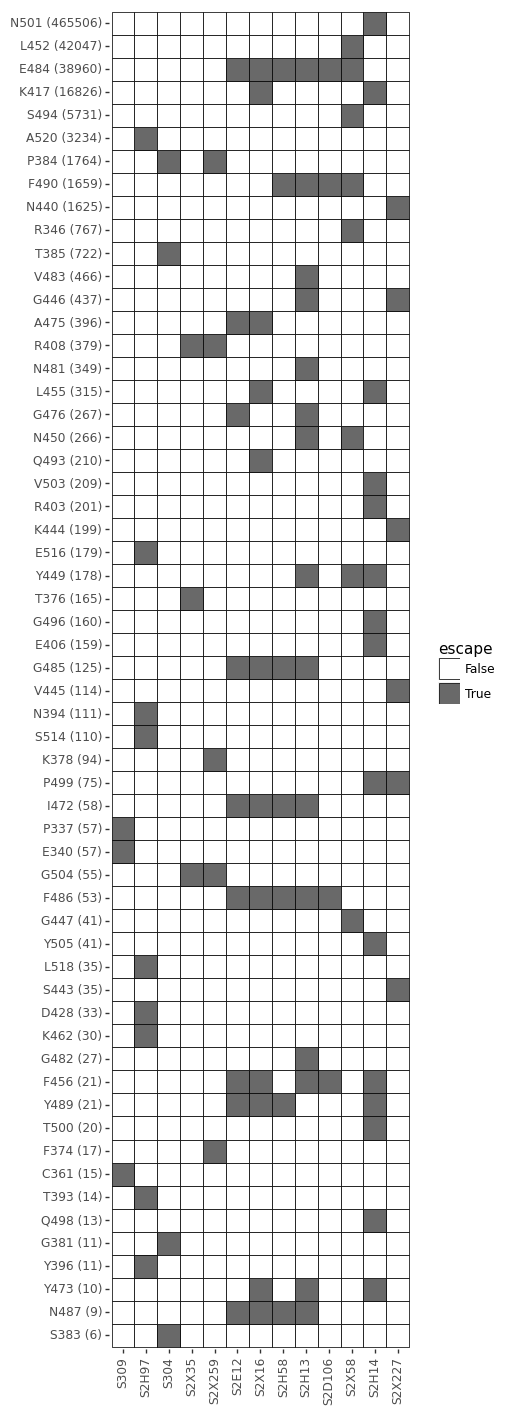

condition,threshold,site,wildtype,count,counts_by_mutation
S2X259,sensitive_max_mut,384,P,1764,"P384L (1206), P384S (519), P384R (30), P384H (5), P384T (2), P384A (2)"
S2X259,sensitive_max_mut,408,R,379,"R408K (192), R408I (119), R408G (56), R408T (10), R408S (2)"
S2X259,sensitive_max_mut,378,K,94,"K378N (76), K378R (12), K378M (5), K378E (1)"
S2X259,sensitive_max_mut,504,G,55,"G504D (24), G504S (23), G504N (3), G504V (2), G504Y (1), G504C (1), G504A (1)"
S2X259,sensitive_max_mut,369,Y,27,"Y369H (16), Y369F (6), Y369C (3), Y369S (1), Y369D (1)"
S2X259,sensitive_max_mut,374,F,17,"F374L (10), F374Y (3), F374S (3), F374V (1)"



Analyzing natural mutations for s2X259
Writing counts of mutations at sites of strong escape to results/GISAID_mutations/s2X259_mutation_counts.csv. First few lines:
Plotting which antibodies / sera are escaped by mutations at all sites of escape with at least 5 mutation counts and saving to results/GISAID_mutations/s2X259_mutation_counts.pdf.


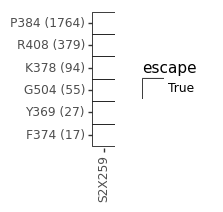

In [10]:
for name, specs in escape_profiles_config.items():
    if 'analyze_natural_mutations' not in specs or not specs['analyze_natural_mutations']:
        continue
    print(f"\nAnalyzing natural mutations for {name}")
    
    conditions = specs['conditions']
    
    threshold = specs['plot_auto_identified_sites']
    if threshold not in sitecounts_strong_sites['threshold'].unique():
        raise ValueError(f"invalid threshold {threshold} for {name}")
    
    # get count for conditions of interest for this subset
    df = (sitecounts_strong_sites
          .query('condition in @conditions')
          .query('threshold == @threshold')
          .assign(condition=lambda x: x['condition'].map(conditions))
          .drop(columns=config['site_metric'])
          )
    countsfile = os.path.join(config['gisaid_mutations_dir'], f"{name}_mutation_counts.csv")
    print(f"Writing counts of mutations at sites of strong escape to {countsfile}. First few lines:")
    display(HTML(df.head(n=10).to_html(index=False)))
    df.to_csv(countsfile, index=False)
    
    # make plot showing escape sites with more than mincounts mutations
    if 'natural_mutations_mincounts' in specs:
        mincounts = specs['natural_mutations_mincounts']
    else:
        mincounts = 5
    plotsfile = os.path.join(config['gisaid_mutations_dir'], f"{name}_mutation_counts.pdf")
    print('Plotting which antibodies / sera are escaped by mutations at all sites of '
          f"escape with at least {mincounts} mutation counts and saving to {plotsfile}.")
    plot_df = (
        # data frame with all combinations of conditions and sites
        pd.DataFrame.from_records([(condition, site) for condition in conditions.values()
                                   for site in df['site'].unique()],
                                  columns=['condition', 'site'])
        # annotate sites of escape
        .merge(df.assign(escape=lambda x: x['count'] >= mincounts)[['condition', 'site', 'escape']],
               how='left',
               validate='one_to_one',
               on=['condition', 'site'])
        .assign(escape=lambda x: x['escape'].fillna(False))
        # add wildtype and counts of mutations at each site
        .merge(sitecounts_strong_sites[['site', 'wildtype', 'count']].drop_duplicates(),
               how='left',
               validate='many_to_one',
               on='site')
        # get only sites with sufficient mutation counts
        .query('count > @mincounts')
        # only get sites where at least one antibody escapes
        .assign(n_escape=lambda x: x.groupby('site')['escape'].transform('sum'))
        .query('n_escape > 0')
        # order conditions, and order sites by count after making nice label
        .assign(site_label=lambda x: x['wildtype'] + x['site'].astype(str) + ' (' + x['count'].astype(str) + ')')
        .sort_values('count')
        .assign(condition=lambda x: pd.Categorical(x['condition'], list(conditions.values()), ordered=True),
                site_label=lambda x: pd.Categorical(x['site_label'], x['site_label'].unique(), ordered=True)
                )
        )
    p = (ggplot(plot_df) +
         aes('condition', 'site_label', fill='escape') +
         geom_tile(color='black', size=0.3) +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(0.3 * plot_df['condition'].nunique(), 0.3 * plot_df['site_label'].nunique()),
               panel_background=element_blank(),
               ) +
         xlab('') +
         ylab('') +
         scale_fill_manual(values=['white', 'dimgray'])
         )
    p.save(plotsfile, verbose=False)
    fig = p.draw()
    display(fig)
    plt.close(fig)

## Plot correlation between escape and natural frequency
First aggregate frequency of mutations and escape fractions:

In [11]:
escape_and_freq = (
    escape_fracs
    .rename(columns={config['mut_metric']: 'mut_escape',
                     config['site_metric']: 'tot_site_escape'})
    .assign(max_site_escape=lambda x: x.groupby(['condition', 'site'])['mut_escape'].transform('max'),
            mean_site_escape=lambda x: x.groupby(['condition', 'site'])['mut_escape'].transform('mean'))
    .merge(mut_counts[['site', 'wildtype', 'mutant', 'frequency']]
                     .rename(columns={'frequency': 'mut_freq'}),
           on=['site', 'wildtype', 'mutant'],
           how='left', validate='many_to_one')
    .assign(mut_freq=lambda x: x['mut_freq'].fillna(0),
            site_freq=lambda x: x.groupby(['condition', 'site'])['mut_freq'].transform('sum'),
            mutation=lambda x: x['wildtype'] + x['site'].astype(str) + x['mutant'],
            )
    )

display(HTML(escape_and_freq.head().to_html()))

,condition,site,wildtype,mutant,mut_escape,tot_site_escape,max_site_escape,mean_site_escape,mut_freq,site_freq,mutation
0,CB6_400,331,N,A,0.001044,0.03952,0.01347,0.00247,0.000000e+00,0.000034,N331A
1,CB6_400,331,N,D,0.002087,0.03952,0.01347,0.00247,8.401660e-07,0.000034,N331D
2,CB6_400,331,N,E,0.001044,0.03952,0.01347,0.00247,0.000000e+00,0.000034,N331E
3,CB6_400,331,N,F,0.001044,0.03952,0.01347,0.00247,0.000000e+00,0.000034,N331F
4,CB6_400,331,N,G,0.005013,0.03952,0.01347,0.00247,0.000000e+00,0.000034,N331G


Now make plots.
Note that you can configure below exactly what variables you want to plot (mutation frequency, mutation escape, site escape, etc):


Analyzing natural mutations for vir_antibodies
Plotting each condition and saving to results/GISAID_mutations/vir_antibodies_escape_vs_freq_by-condition.pdf


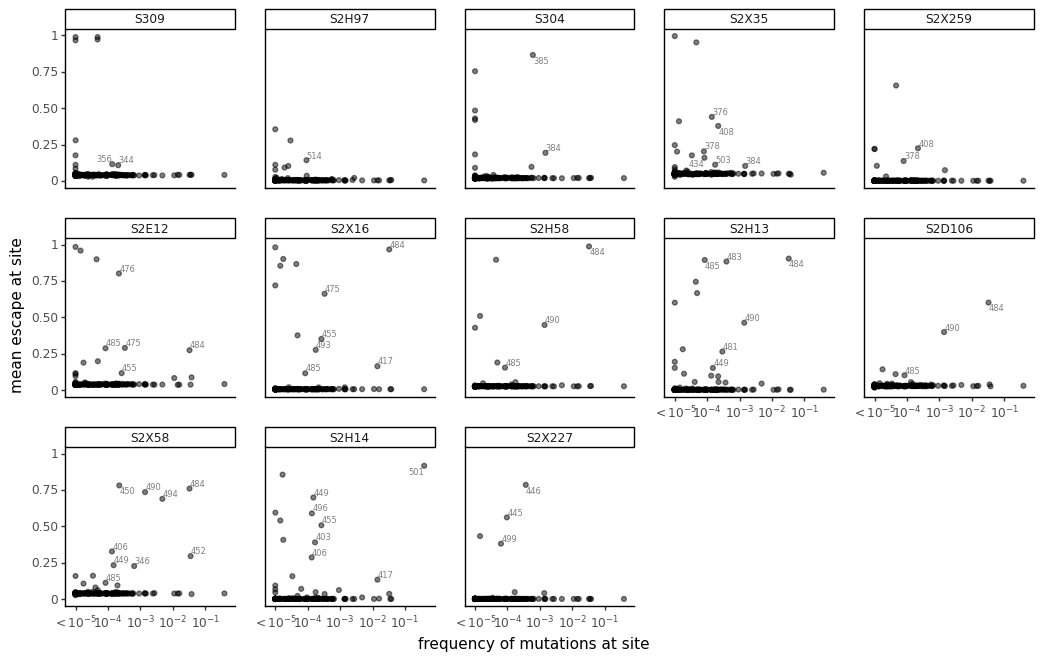

Plotting average across conditions and saving to results/GISAID_mutations/vir_antibodies_escape_vs_freq_average.pdf


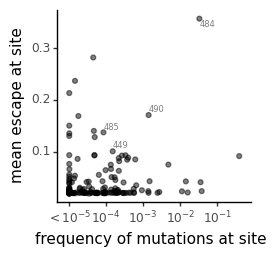


Analyzing natural mutations for s2X259
Plotting each condition and saving to results/GISAID_mutations/s2X259_escape_vs_freq_by-condition.pdf


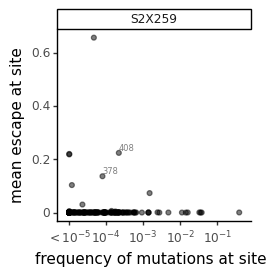

Plotting average across conditions and saving to results/GISAID_mutations/s2X259_escape_vs_freq_average.pdf


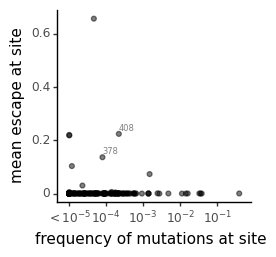

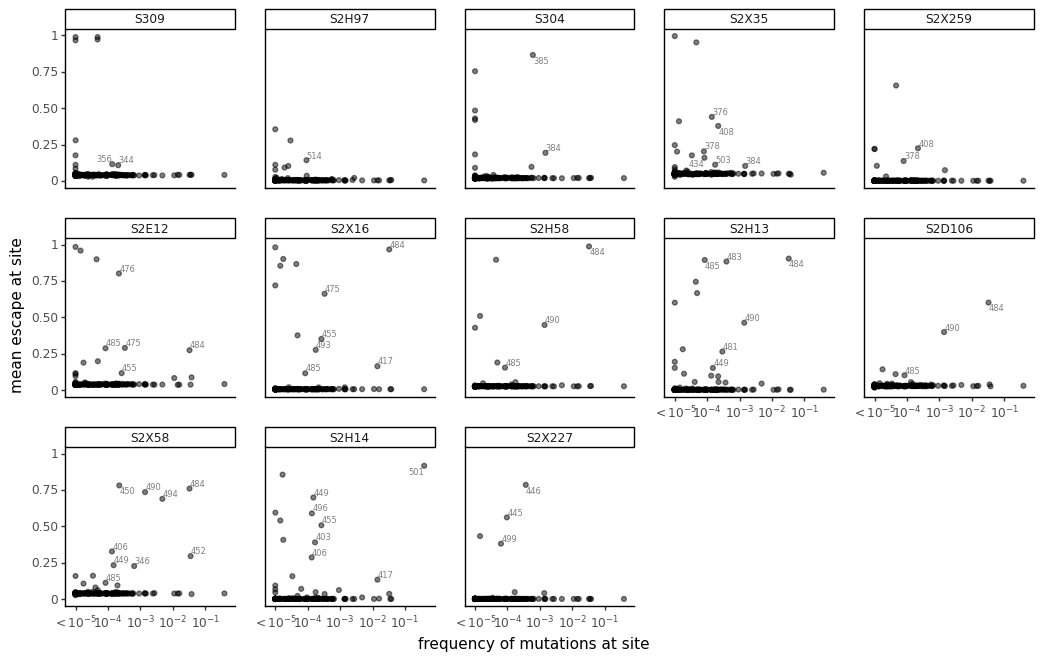

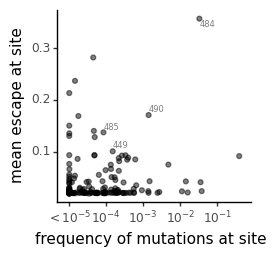

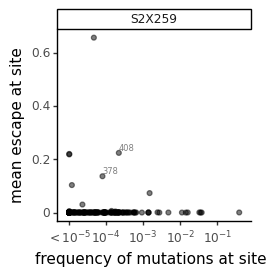

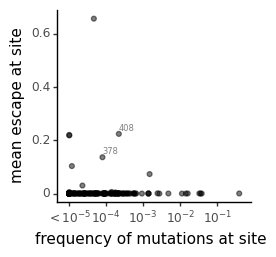

In [12]:
# all the parameters below have the indicated defaults, but can be set in `escape_profiles_config`
# via analyze_natural_mutations_specs
default_analysis_specs = {
    'maxcol': 5,  # maximum columns in plot
    'minfreq': 1e-5,  # collapse any natural frequencies < this
    'freq': 'site_freq',  # type of frequency to plot: mut_freq or site_freq
    'escape': 'mean_site_escape',  # type of escape to plot: mean_site_escape, mut_escape, max_site_escape, tot_site_escape
    'xlabel': 'frequency of mutations at site',
    'ylabel': 'mean escape at site',
    'label_minfreq': 5e-5,  # label points with frequency >= this and...
    'label_minescape': 0.1,  # label points with escape >= this
    'also_label': [],  # also label any points (sites or mutations) listed here
    'label_font_size': 6,  # font size for labeling points
    'default_color': 'black',  # color for points not otherwise specified
    'default_alpha': 0.5,  # default alpha if not specified
    'set_point_color': {},  # set color; key by site / mutation, value is color
    'set_point_alpha': {},  # set alpha; key by site / mutations, value is alpha
    }
label_minfreq = 5e-5  # label points with frequency >= this
label_minescape = 0.05  # label points with escape >= this

for name, specs in escape_profiles_config.items():
    if 'analyze_natural_mutations' not in specs or not specs['analyze_natural_mutations']:
        continue
    print(f"\nAnalyzing natural mutations for {name}")
    
    analysis_specs = copy.deepcopy(default_analysis_specs)
    if 'analyze_natural_mutations_specs' in specs:
        for key, val in specs['analyze_natural_mutations_specs'].items():
            analysis_specs[key] = val
    
    conditions = specs['conditions']
    
    if 'site' in analysis_specs['freq'] and 'site' in analysis_specs['escape']:
        ptlabel = 'site'
    else:
        ptlabel = 'mutation'
    
    df = (escape_and_freq
          .query('condition in @conditions')
          .assign(condition=lambda x: x['condition'].map(conditions))
          .assign(**{analysis_specs['freq']: lambda x: x[analysis_specs['freq']].clip(lower=analysis_specs['minfreq'])})
          [['condition', analysis_specs['escape'], analysis_specs['freq'], ptlabel]]
          .drop_duplicates()
          )

    assert len(conditions) == df['condition'].nunique()
    
    for avg_conditions in (False, True):
        
        if avg_conditions:
            plot_df = df.groupby(ptlabel, as_index=False).aggregate({analysis_specs['freq']: 'mean',
                                                                     analysis_specs['escape']: 'mean'})
            nrow = ncol = 1
            plotfile = os.path.join(config['gisaid_mutations_dir'],
                                    f"{name}_escape_vs_freq_average.pdf")
            print(f"Plotting average across conditions and saving to {plotfile}")
        else:
            nrow = math.ceil(len(conditions) / analysis_specs['maxcol'])
            ncol = min(len(conditions), analysis_specs['maxcol'])
            plot_df = df.copy()
            # make condition categorical to maintain order 
            plot_df=plot_df.assign(condition=lambda x: pd.Categorical(x['condition'], 
                                                                      list(conditions.values()), 
                                                                      ordered=True)
                                  )
            plotfile = os.path.join(config['gisaid_mutations_dir'],
                                    f"{name}_escape_vs_freq_by-condition.pdf")
            print(f"Plotting each condition and saving to {plotfile}")
         
        # color points and set alpha
        set_point_color = collections.defaultdict(lambda: analysis_specs['default_color'])
        set_point_alpha = collections.defaultdict(lambda: analysis_specs['default_alpha'])
        for point, color in analysis_specs['set_point_color'].items():
            set_point_color[point] = color
        for point, alpha in analysis_specs['set_point_alpha'].items():
            set_point_alpha[point] = alpha
        plot_df['color'] = plot_df[ptlabel].map(set_point_color)
        plot_df['alpha'] = plot_df[ptlabel].map(set_point_alpha)
        # need to make color categorical to assign as aesthetic
        colors = plot_df['color'].unique()
        plot_df['color'] = pd.Categorical(plot_df['color'], colors, ordered=True)
            
        label_df = (plot_df
                    .assign(label=lambda x: x[ptlabel].isin(analysis_specs['also_label']))
                    .query(f"label or ({analysis_specs['freq']} >= {analysis_specs['label_minfreq']})")
                    .query(f"label or ({analysis_specs['escape']} >= {analysis_specs['label_minescape']})")
                    )
        
        maxfreq = plot_df[analysis_specs['freq']].max()
        assert analysis_specs['minfreq'] == 10**(int(math.log10(analysis_specs['minfreq'])))
        logxbreaks = list(range(int(math.log10(analysis_specs['minfreq'])), round(math.log10(maxfreq)) + 1, 1))
        xbreaks = [10**logx for logx in logxbreaks]
        xlabels = [f"$10^{{{logx}}}$" for logx in logxbreaks]
        xlabels[0] = f"$<{xlabels[0][1:]}"
        
        p = (ggplot(plot_df) +
             aes(analysis_specs['freq'], analysis_specs['escape'], color='color', alpha='alpha') +
             geom_point() +
             geom_text(data=label_df,
                       mapping=aes(label=ptlabel),
                       size=analysis_specs['label_font_size'],
                       adjust_text={'expand_points': (1.05, 1.2),
                                    'expand_text': (1.05, 1.2)},
                       ) +
             theme_classic() +
             theme(figure_size=(2.5 * ncol, 2.5 * nrow),
                   panel_spacing=0.3,
                   legend_position='none',
                   ) +
             scale_x_log10(name=analysis_specs['xlabel'],
                           breaks=xbreaks,
                           labels=xlabels,
                           expand=(0.07, 0)) +
             ylab(analysis_specs['ylabel']) +
             scale_color_manual(values=colors) +
             scale_alpha_continuous(limits=(0, 1), range=(0, 1))
             )
        if not avg_conditions:
            p = p + facet_wrap('~ condition', ncol=ncol)
        p.save(plotfile, verbose=False)
        fig = p.draw()
        display(fig)
       # plt.close(fig)